# Brain Tumor Classification

In this notebook, I'll be going through step by step on how we can develop a model for unstructured data like images. Since our data is non-tabular, a neural network would be more suitable to handle the data. We will try to train our own model first , then try implementing a transfer learning based approach later with VGG16! I will also be implementing feature engineering as inspired by Ruslan Klymentiev in his kaggle notebook [https://www.kaggle.com/code/ruslankl/brain-tumor-detection-v1-0-cnn-vgg-16]

## Exploratory Data Analysis

In [ ]:
# Use the following to unzip the file if need be

# importing the zipfile module 
#from zipfile import ZipFile 
  
# loading the temp.zip and creating a zip object 
#with ZipFile("./Brain-Tumor-Files.zip", 'r') as zObject: 
  
    # Extracting all the members of the zip  
    # into a specific location. 
    #zObject.extractall() 

What we have for data is a bunch of images of cases where there is a brain tumor (y=1) and there isn't a brain tumor (y=0). What we'll first do is plot a single instance of the data

In [2]:
# Import all required libraries here, it should take about 15s

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.utils import load_img, img_to_array
from skimage.transform import resize
import cv2
import os
from sklearn.model_selection import train_test_split
from shutil import copyfile

Now that we've got that out of the way, let's visualize a couple examples of our data from the 'no' folder and the 'yes' folder to see what we're working with

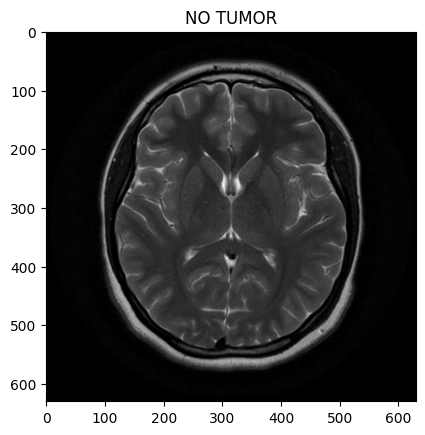

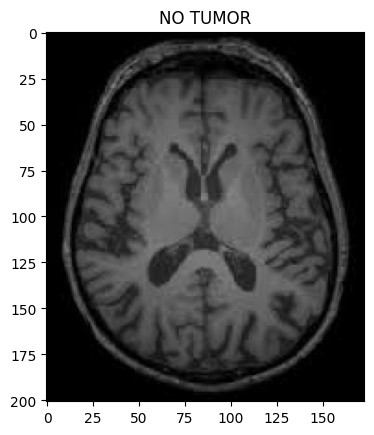

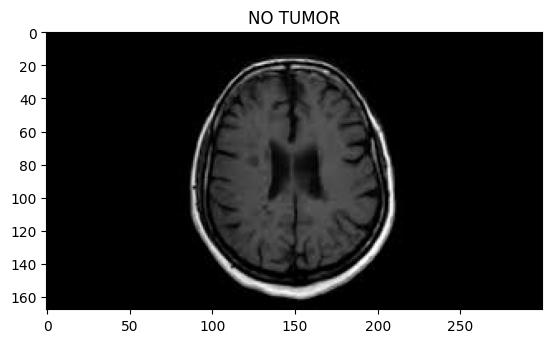

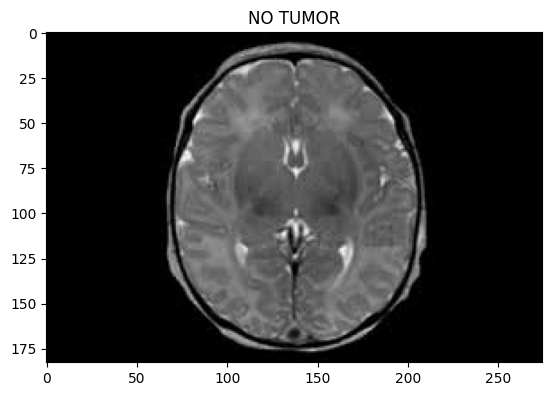

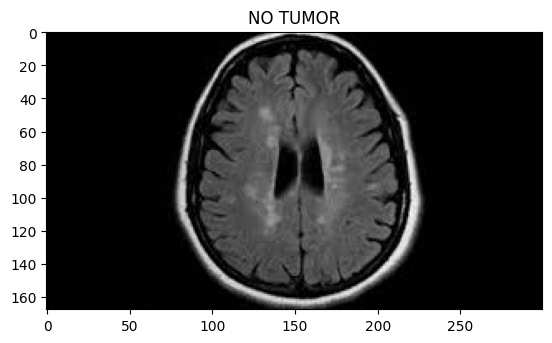

In [12]:
directory_path_no = './brain_tumor_dataset/no/'
image_filenames_no = os.listdir(directory_path_no)
image_path_no = [os.path.join(directory_path_no, filename) for filename in image_filenames_no]
for image in image_path_no[:5]:
    img = load_img(image)
    plt.imshow(img)
    plt.title('NO TUMOR')
    plt.show()

In [21]:
count = 1
for image in image_path_no[:5]:
    img = load_img(image)
    img_array = img_to_array(img)
    print(f"No Image {count}: {img_array.shape}")
    count += 1

No Image 1: (630, 630, 3)
No Image 2: (201, 173, 3)
No Image 3: (168, 300, 3)
No Image 4: (183, 275, 3)
No Image 5: (168, 300, 3)


So what we can see are images with 3 color channels RGB, and each image has a different size which will be problematic when we feed it into the neural network later on as our input data must be of same dimensions. 

We'll just keep in mind to add resizing and cropping to the data preprocessing procedure. In the meantime, let's continue visualizing examples for the 'yes' folder

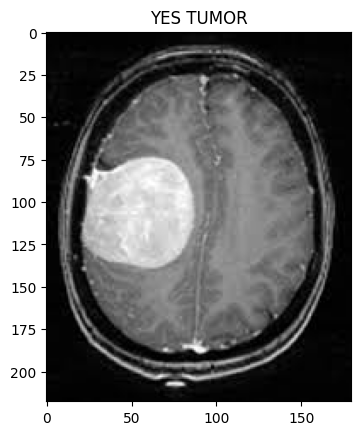

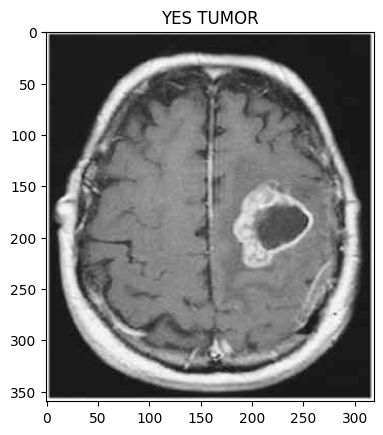

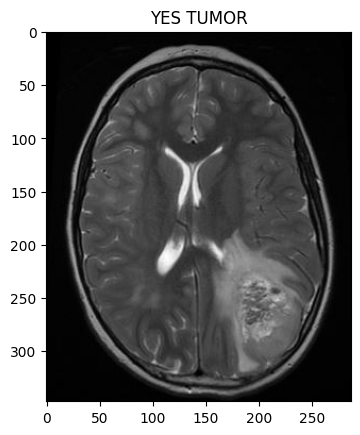

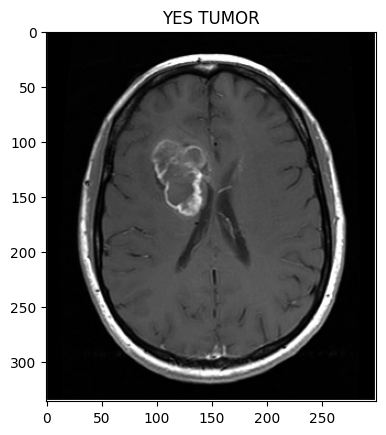

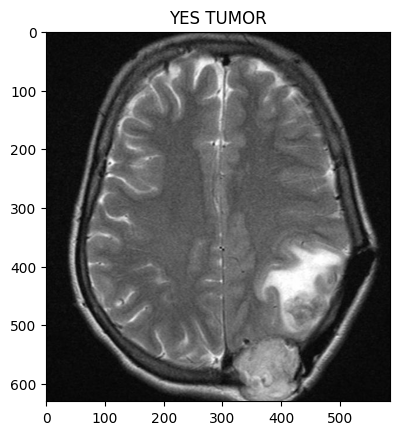

In [22]:
directory_path_yes = './brain_tumor_dataset/yes/'
image_filenames_yes = os.listdir(directory_path_yes)
image_path_yes = [os.path.join(directory_path_yes, filename) for filename in image_filenames_yes]
for image in image_path_yes[:5]:
    img = load_img(image)
    plt.imshow(img)
    plt.title('YES TUMOR')
    plt.show()

In [24]:
count = 1
for image in image_path_yes[:5]:
    img = load_img(image)
    img_array = img_to_array(img)
    print(f"Yes Image {count}: {img_array.shape}")
    count += 1

Yes Image 1: (218, 180, 3)
Yes Image 2: (360, 319, 3)
Yes Image 3: (348, 287, 3)
Yes Image 4: (336, 300, 3)
Yes Image 5: (630, 587, 3)


Similar to the 'no' folder, we have images with 3 color channels and of varying sizes. Let's move on and start looking at the different ways we can pre-process the data.

## Data Preprocessing

The first thing we're going to do is crop the data, and there are two main reasons for this:

1. Differing image sizes is problematic (computationally expensive) as input layer of our model will require images of same dimensions to be fed into it.

2. By cropping the image data, we're able to help maintain the spatial information so the neural network would focus on relevant regions (i.e: focus on the brain and not the black edges surrounding it.)

So let's start with cropping

### Cropping With Contours
The method outlined here can be found here [https://pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/]. 

I will also try to reiterate what's said on the article and give my own explanation regarding the method as it is my first time implementing this!

The process can be broken down into a 5 steps:

1. Import Relevant libraries
2. Load and preprocess image
3. Thresholding and Morphological operations
4. Find contours
5. Among those contours, find the largets countours

we'll dissect each step as we go along so for now, let's import the relevant libraries

In [3]:
import imutils
import cv2

We will use cv2 to for the majority of the steps. imutils on the other hand will be used to extract the contours from the result.

I know it's a little vague right now, but hopefully it'll become clearer as we progress!

Next, let's load the image and preprocess it.

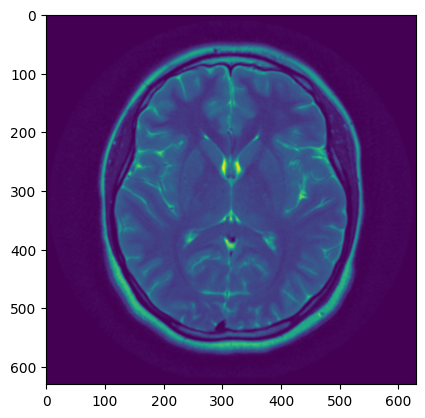

In [4]:
# Load the image
image = cv2.imread('./brain_tumor_dataset/no/1 no.jpeg')

# Convert To grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray)
# img_to_array(gray).shape

# Apply a blur to the image
gray = cv2.GaussianBlur(gray, (5,5), 0)
plt.imshow(gray)

Once, we've loaded the image, we convert the image to grayscale. If you want to see what that does to the image, just plot the image with plt.imshow(gray). What the conversion will do is essentially change our image's color channels from 3 representing RGB to 1 which represents a monochrome image. (You can check this by converting image to array and calling .shape on the image array)

The reason for converting to grayscale is to reduce "noise" in our image. Noise is essentially unwanted or random variations in pixel values that can distort or degrade the quality of an image.

Then, we will slightly blur the image. This is actually to smoothen the image. In a more mathematical sense, we are essentially averaging out the rapid changes in pixel intensity for our images [https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html]

Moving on to the next step, we will be thresholding and applying morphological operations on our image

In [5]:
# Convert to binary image
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
# plt.imshow(thresh)
# thresh.shape

# Erode the image
thresh = cv2.erode(thresh, None, iterations=2)
#plt.imshow(thresh)

# Dilate the image
thresh = cv2.dilate(thresh, None, iterations=2)
# plt.imshow(thresh)

The reason we convert it to binary image format first is to improve accuracy when computing the contours. When you call cv2.threshold it returns (threshold value, image after the thresholding operation is implemented). If you want to see what it does to the image, I highly recommend calling plt.imshow(thresh). If you check it's shape with thresh.shape you'll see that the colour channel is no more.

The following steps, erosion to remove small regions of noise and dilation to enhance the remaining regions

We will now continue with actually computing the contours and getting the biggest one. 

In [6]:
# Find contours in thresholded image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Extract contours from the results
cnts = imutils.grab_contours(cnts)

# Find Largest Contour
c = max(cnts, key=cv2.contourArea)



# The code I've written here will draw the contour so you can see what exactly we're grabbing
#image_with_contour = image.copy()
#cv2.drawContours(image_with_contour, [c], -1, (0, 255, 0), 2)

# Display the original image and the image with the contour
#cv2.imshow("Original Image", image)
#cv2.imshow("Image with Contour", image_with_contour)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

First we compute the contours. findContours takes 3 arguments: 

1. source image
2. contour retrieval mode: RETR_EXTERNAL gets the outermost contour
3. contour approximation mode: CHAIN_APPROX_SIMPLE - It removes all redundant points and compresses the contour, thereby saving memory. Otherwise you would store all points on the boundary which is unneccessary. Intuitively, you don't need every point on a line to represent the line, you just need a few

Then grab the contours.

Among the contours, take the the contour with the biggest area. This is what specifying key=cv2.contourArea does. It iterates through cnts which contains the contours, look for the one with the biggest area, and return that contour.

The next step here is to find the extreme points on this brain image.

In [7]:
# Find the extreme points
ext_left = tuple(c[c[:, :, 0].argmin()][0])
ext_right = tuple(c[c[:, :, 0].argmax()][0])
ext_top = tuple(c[c[:, :, 1].argmin()][0])
ext_bot = tuple(c[c[:, :, 1].argmax()][0])

In [18]:
# c[c[:, :, 0].argmin()][0].shape 

(2,)

The general structure for finding the extreme points is roughly the same:

1. For Horizontal axis (x-axis)

- a = c[:,:,0] -> gets all points on the x-axis
- b = a.argmin() -> gets index of the smallest x value
- d = c[b][0] -> to extract the row with the small x-value, without [0], you would have a numpy array of shape (1,2) but we want (2,)
- e = tuple(d) -> convert to tuple (x,y) so that we can plot it later to see where the points like

2. For Vertical axis (y-axis)

- a = c[:,:,1] -> gets all points on the y-axis
- b = a.argmin() -> gets index of the smallest y value
- d = c[b][0] -> to extract the row with the small y-value, without [0], you would have a numpy array of shape (1,2) but we want (2,)
- e = tuple(d) -> convert to tuple (x,y) so that we can plot it later to see where the points like

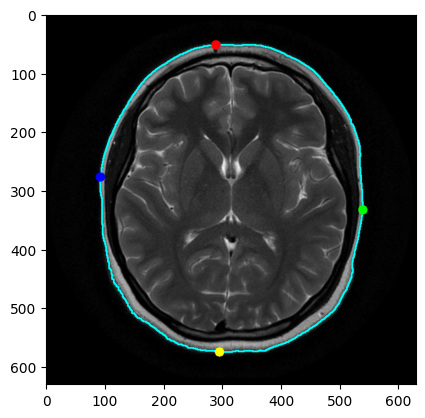

In [19]:
cv2.drawContours(image, [c], -1, (0, 255, 255), 2)
cv2.circle(image, ext_left, 8, (0, 0, 255), -1)
cv2.circle(image, ext_right, 8, (0, 255, 0), -1)
cv2.circle(image, ext_top, 8, (255, 0, 0), -1)
cv2.circle(image, ext_bot, 8, (255, 255, 0), -1)

plt.imshow(image)

# Can use cv2 to show but I personally found that it crashes the kernel so I avoid it
#cv2.imshow("Image", image)
#cv2.waitKey(0)